In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import bokeh.plotting as bpl
import cv2
import glob
import logging
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
import numpy as np
import os

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()

import matplotlib as mpl
mpl.rcParams.update({
    'figure.figsize': (18, 13),
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [23]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

# Compare caiman vs manual seg

In [37]:
# filename = '//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/i1329/201209/002/caiman_002_vertical.hdf5'
# filename = '//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/i1329/201209/002/caiman_002_1200_eval.hdf5'
filename = 'caiman_002_full.hdf5'
cnm = cnmf.load_CNMF(filename, n_processes=n_processes, dview=dview)

In [396]:
def plot_contours_LL(A, Cn, thr=None, thr_method='max', maxthr=0.2, nrgthr=0.9, display_numbers=True, max_number=None,
                     cmap=None, swap_dim=False, colors='w', alpha=0.5, linewidth=1.0, swap_background=False,
                     vmin=None, vmax=None, coordinates=None,
                     contour_args={}, number_args={}, **kwargs):
    """Plots contour of spatial components against a background image and returns their coordinates
       LL: added alpha and linewidth

     Args:
         A:   np.ndarray or sparse matrix
                   Matrix of Spatial components (d x K)
    
         Cn:  np.ndarray (2D)
                   Background image (e.g. mean, correlation)
    
         thr_method: [optional] string
                  Method of thresholding:
                      'max' sets to zero pixels that have value less than a fraction of the max value
                      'nrg' keeps the pixels that contribute up to a specified fraction of the energy
    
         maxthr: [optional] scalar
                    Threshold of max value
    
         nrgthr: [optional] scalar
                    Threshold of energy
    
         thr: scalar between 0 and 1
                   Energy threshold for computing contours (default 0.9)
                   Kept for backwards compatibility. If not None then thr_method = 'nrg', and nrgthr = thr
    
         display_number:     Boolean
                   Display number of ROIs if checked (default True)
    
         max_number:    int
                   Display the number for only the first max_number components (default None, display all numbers)
    
         cmap:     string
                   User specifies the colormap (default None, default colormap)

     Returns:
          coordinates: list of coordinates with center of mass, contour plot coordinates and bounding box for each component
    """

    from caiman.utils.visualization import get_contours #, plot_contours
    import pylab as pl

    if swap_dim:
        Cn = Cn.T
        print('Swapping dim')

    if thr is None:
        try:
            thr = {'nrg': nrgthr, 'max': maxthr}[thr_method]
        except KeyError:
            thr = maxthr
    else:
        thr_method = 'nrg'


    for key in ['c', 'colors', 'line_color']:
        if key in kwargs.keys():
            color = kwargs[key]
            kwargs.pop(key)

    ax = pl.gca()
    if swap_background == False:
        if vmax is None and vmin is None:
            pl.imshow(Cn, interpolation=None, cmap=cmap,
                      vmin=np.percentile(Cn[~np.isnan(Cn)], 1),
                      vmax=np.percentile(Cn[~np.isnan(Cn)], 99))
        else:
            pl.imshow(Cn, interpolation=None, cmap=cmap, vmin=vmin, vmax=vmax)

    if coordinates is None:
        coordinates = get_contours(A, np.shape(Cn), thr, thr_method, swap_dim)
    for c in coordinates:
        v = c['coordinates']
        c['bbox'] = [np.floor(np.nanmin(v[:, 1])), np.ceil(np.nanmax(v[:, 1])),
                     np.floor(np.nanmin(v[:, 0])), np.ceil(np.nanmax(v[:, 0]))]
        pl.plot(*v.T, c=colors, alpha=alpha, linewidth=linewidth, **contour_args)

    if display_numbers:
        d1, d2 = np.shape(Cn)
        d, nr = np.shape(A)
        cm = com(A, d1, d2)
        if max_number is None:
            max_number = A.shape[1]
        for i in range(np.minimum(nr, max_number)):
            if swap_dim:
                ax.text(cm[i, 0], cm[i, 1], str(i + 1), color=colors, **number_args)
            else:
                ax.text(cm[i, 1], cm[i, 0], str(i + 1), color=colors, **number_args)
    return coordinates

## contour on caiman corr_img

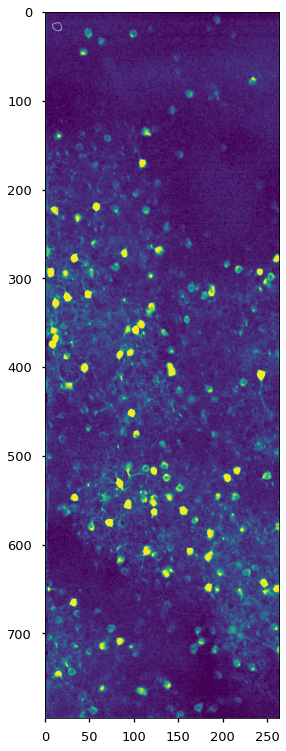

In [134]:
crd = plot_contours_LL(cnm.estimates.A[:, 0], Cn, thr=0.9, display_numbers=False, alpha=0.5, linewidth=1)

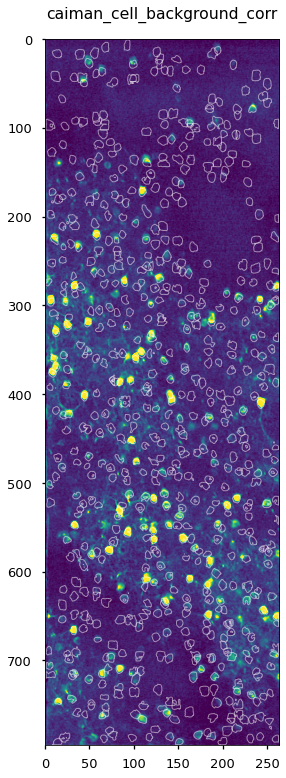

In [409]:
cell_id_passed = cnm.estimates.idx_components[pass_arr]
for cell_id in cell_id_passed:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, alpha=0.5, linewidth=1, display_numbers=False);
plt.title('caiman_cell_background_corr', pad=20)
plt.savefig('caiman_cell_background_corr.pdf', format='pdf', bbox_inches='tight')

In [386]:
# type(cnm.estimates.idx_components[~np.array(pass_arr)])
type(cnm.estimates.idx_components_bad)

numpy.ndarray

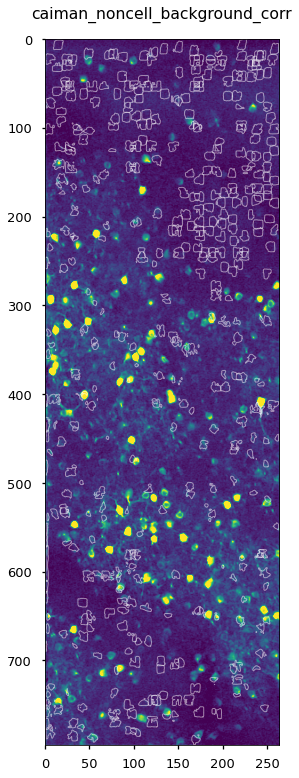

In [408]:
cell_id_failed = np.hstack((cnm.estimates.idx_components_bad, 
                            cnm.estimates.idx_components[~np.array(pass_arr)]))
# len(cell_id_failed), len(cnm.estimates.idx_components_bad)

for cell_id in cell_id_failed:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, alpha=0.5, linewidth=1, display_numbers=False);
plt.title('caiman_noncell_background_corr', pad=20)
plt.savefig('caiman_noncell_background_corr.pdf', format='pdf', bbox_inches='tight')

## manual

In [83]:
from custom_functions import loadmat
mat = 'Z:/All_Staff/home/lan/Analysis/2P/201209_i1329/201209_i1329_runs-002/201209_i1329_runs-002_mask_cell_addfake.mat'
t = loadmat(mat)
t['mask_cell'].shape, np.max(t['mask_cell'])

((264, 796), 70)

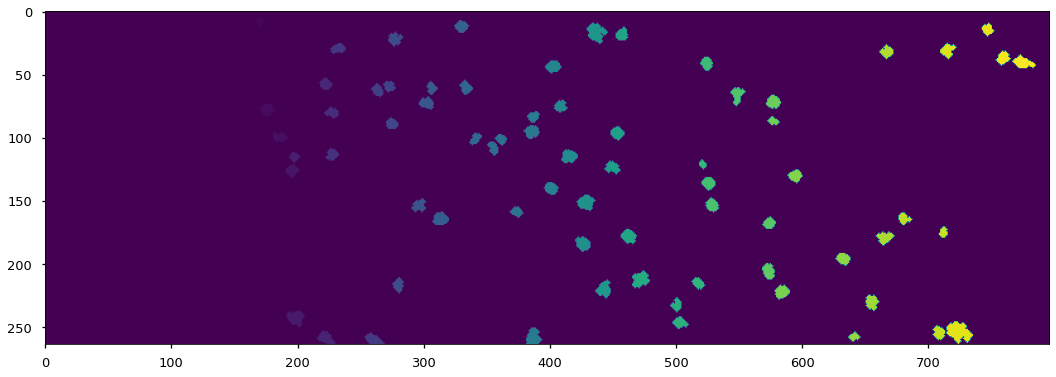

In [84]:
plt.imshow(t['mask_cell'])
# np.unique(t['mask_cell'])

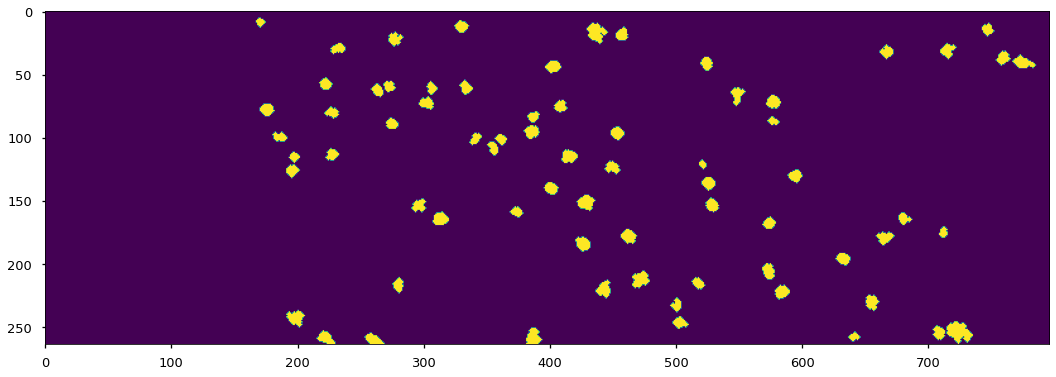

In [85]:
seg_ref = t['mask_cell'].copy()
sz = seg_ref.shape

seg_ref = seg_ref.flatten()
seg_ref[seg_ref>1] = 1
seg_ref = seg_ref.reshape(sz)

plt.imshow(seg_ref)

## max proj & top perc

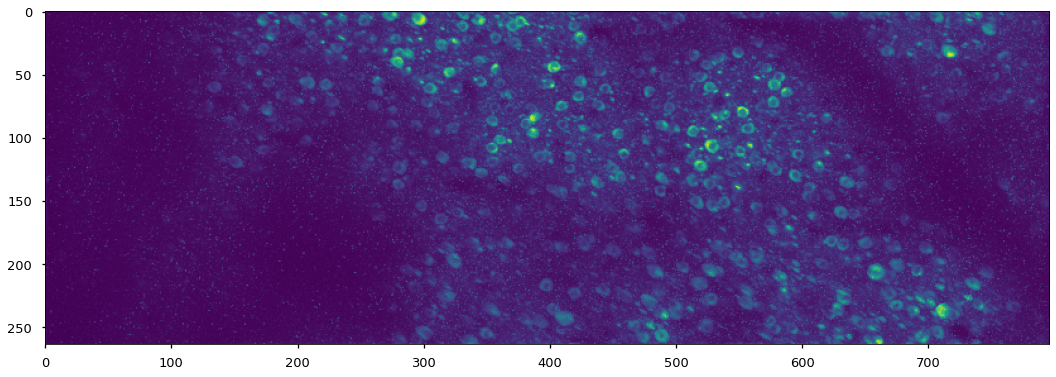

In [394]:
mat = 'Z:/All_Staff/home/lan/Analysis/2P/201209_i1329/201209_i1329_runs-002/data_max.mat'
t = loadmat(mat)

data_max_projection = t['data_max_projection']
data_top_perc = t['data_top_perc']

plt.imshow(data_max_projection)
# plt.imshow(data_top_perc)

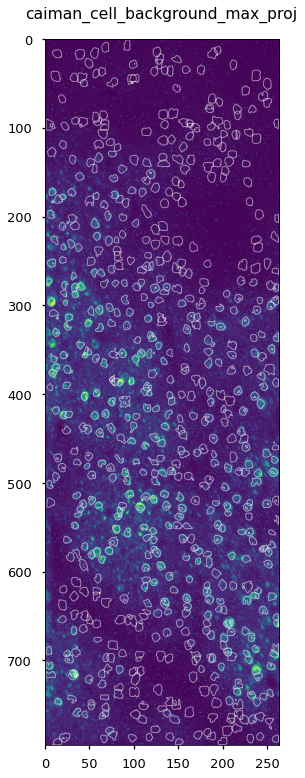

In [410]:
for cell_id in cell_id_passed:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, colors='w',
                         alpha=0.5, linewidth=1, swap_background=True, display_numbers=False);
# plt.imshow(seg_ref.T);
plt.imshow(data_max_projection.T)

plt.title('caiman_cell_background_max_proj', pad=20)
plt.savefig('caiman_cell_background_max_proj.pdf', format='pdf', bbox_inches='tight')

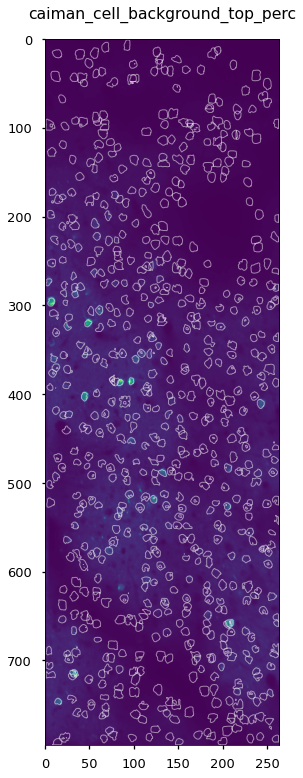

In [411]:
for cell_id in cell_id_passed:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, colors='w',
                         alpha=0.5, linewidth=1, swap_background=True, display_numbers=False);
plt.imshow(data_top_perc.T)

plt.title('caiman_cell_background_top_perc', pad=20)
plt.savefig('caiman_cell_background_top_perc.pdf', format='pdf', bbox_inches='tight')

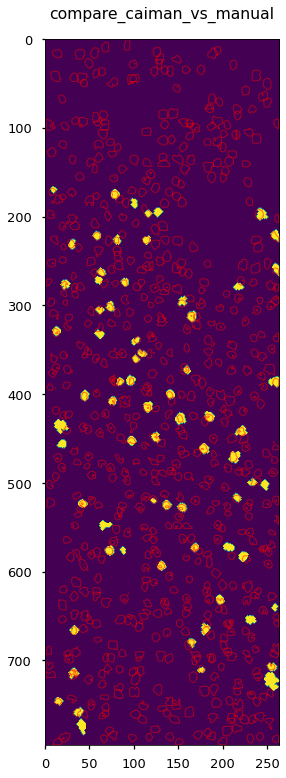

In [412]:
for cell_id in cell_id_passed:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, colors='r',
                         alpha=0.5, linewidth=1, swap_background=True, display_numbers=False);
plt.imshow(seg_ref.T);

plt.title('compare_caiman_vs_manual', pad=20)
plt.savefig('compare_caiman_vs_manual_strict.pdf', format='pdf', bbox_inches='tight')
# 12 cells included in manual but not in caiman

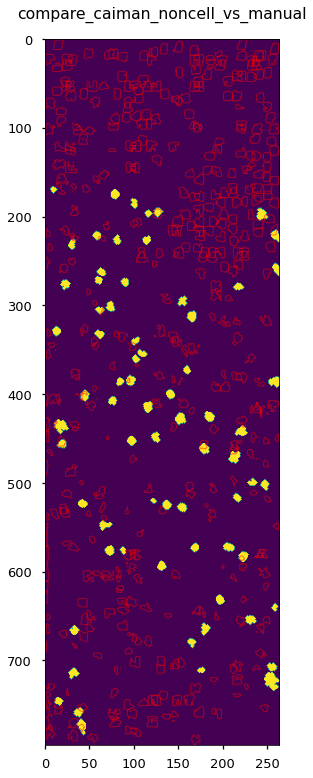

In [413]:
for cell_id in cell_id_failed:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, colors='r',
                         alpha=0.5, linewidth=1, swap_background=True, display_numbers=False);
plt.imshow(seg_ref.T);

plt.title('compare_caiman_noncell_vs_manual', pad=20)
plt.savefig('compare_caiman_bad_vs_manual_strict.pdf', format='pdf', bbox_inches='tight')
# 6/12 cells were categorized as "bad" by caiman, the remaining 6 are maybe missing

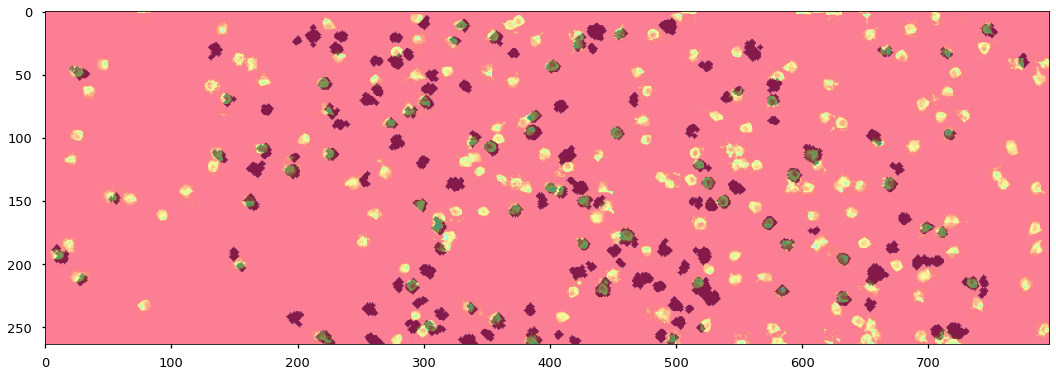

In [40]:
# this is comparing caiman 1200 tif vs manual, not full tif
# # check how to get all cell map: cell spatial info is in a sparse matrix. non-cell area = 0
# from bokeh.plotting import figure, show

# es = cnm.estimates
# t = es.A[:,130].toarray().reshape([796,264], order='F')
# plt.imshow(t[50:100, 230:])
# # plt.imshow(t)

# ## add up every cell loc matrix to get overlaid all-cell map

# cell_map = np.zeros([796,264])
# for i in np.arange(es.A.shape[1]):
#     t = es.A[:,i].toarray().reshape([796,264], order='F')
#     cell_map = cell_map + t
    
# fig = plt.figure(figsize=[16,7])
# fig = plt.imshow(cell_map)

# seg_caiman = cell_map.T
# im1 = plt.imshow(seg_caiman, cmap='rainbow_alpha', alpha=0.99)
# im2 = plt.imshow(seg_ref, cmap='Blues', alpha=0.5)
# plt.show()

In [6]:
mmap_name = '//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/i1329/201209/002/002_vertical_els__d1_796_d2_264_d3_1_order_F_frames_1200_.mmap'
Yr, dims, T = cm.load_memmap(mmap_name)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 

Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0

# cnm.estimates.plot_contours_nb(img=Cn, idx=cnm.estimates.idx_components)
# cnm.estimates.plot_contours_nb(img=Cn)

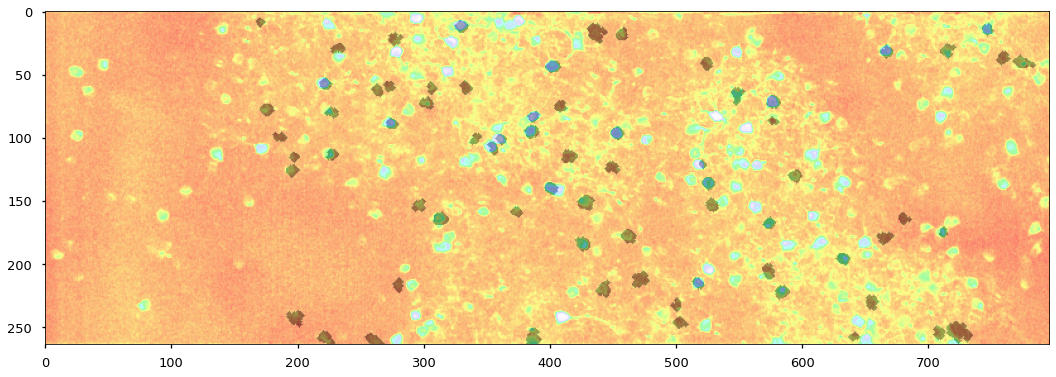

In [90]:
# compare caiman max correlation img vs manual segmentation (strict, but wrong time window)
corr_caiman = Cn.T

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# get colormap
ncolors = 256
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))
# change alpha values
color_array[:,-1] = np.linspace(1.0,0.0,ncolors)
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)
# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

im1 = plt.imshow(corr_caiman, cmap='rainbow_alpha', alpha=1)
im2 = plt.imshow(seg_ref, cmap='Blues', alpha=0.4)
plt.show()

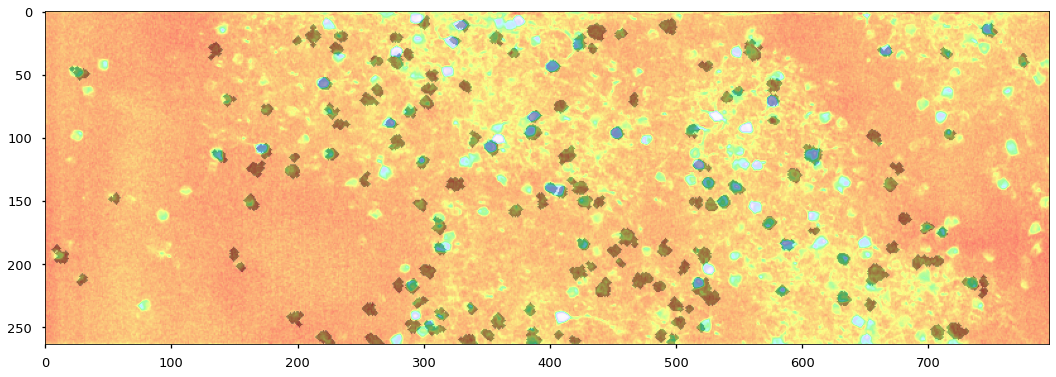

In [81]:
# use manual segmentation (blind, less strict)
corr_caiman = Cn.T
im1 = plt.imshow(corr_caiman, cmap='rainbow_alpha', alpha=1)
im2 = plt.imshow(seg_ref, cmap='Blues', alpha=0.4)
plt.show()

# Component eval

In [157]:
def caiman_reasoning(idx_list, is_cell, sort_by, save_flag):

    import pylab as pl
    from caiman.base.rois import com
    from caiman.utils.visualization import plot_contours, get_contours
    from post_analysis import check_eval_results_LL

    for component_id in idx_list:
        snr, rval, cnn = check_eval_results_LL(cnm, [component_id], print_score=False)
#         if (rval >= r_max) and (snr < snr_max) and (cnn < cnn_max):

        crd = plot_contours_LL(cnm.estimates.A[:, component_id], Cn, thr=0.9, display_numbers=False);
        plt.clf()
        plt.figure()

        ypos = np.floor(crd[0]['CoM']).astype(int)[0] # y position of caiman segmented cell's center of mass
        proximity_range = 50 # plot how many pixels around CoM
        Cn_chunk = Cn[max(ypos-proximity_range, 0):min(ypos+proximity_range, Cn.shape[0]), :] # do not exceed Cn nrow
        plt.imshow(Cn_chunk)

        crd_converted = crd[0]['coordinates'].copy()
        crd_converted[:,1] = crd_converted[:,1] - max(ypos-proximity_range, 0) # origin (0 position) shifting due to edge
        pl.plot(*crd_converted.T, color='red', alpha=1)

        snr_min = cnm.params.quality['SNR_lowest']
        snr_max = cnm.params.quality['min_SNR']
        r_min = cnm.params.quality['rval_lowest']
        r_max = cnm.params.quality['rval_thr']
        cnn_min = cnm.params.quality['cnn_lowest']
        cnn_max = cnm.params.quality['min_cnn_thr']

        color_snr = 'black'
        if snr < snr_min: color_snr = 'red';
        elif snr >= snr_max: color_snr = 'green';
        color_rval = 'black'
        if rval < r_min: color_rval = 'red';
        elif rval >= r_max: color_rval = 'green';
        color_cnn = 'black'
        if cnn < cnn_min: color_cnn = 'red';
        elif cnn >= cnn_max: color_cnn = 'green';

        txt_snr = 'snr = ' + ('%.2f' % snr) + " @ threshold (" + ('%.2f' % snr_min) + ", " + ('%.2f' % snr_max) + ")"
        txt_rval = 'rval = ' + ('%.2f' % rval) + " @ threshold (" + ('%.2f' % r_min) + ", " + ('%.2f' % r_max) + ")"
        txt_cnn = 'cnn = ' + ('%.2f' % cnn) + " @ threshold (" + ('%.2f' % cnn_min) + ", " + ('%.2f' % cnn_max) + ")"

        txt_ypos = 0.2
        plt.text(0.4, txt_ypos, txt_snr, fontsize=14, color=color_snr, transform=plt.gcf().transFigure)
        plt.text(0.4, txt_ypos-0.02, txt_rval, fontsize=14, color=color_rval, transform=plt.gcf().transFigure)
        plt.text(0.4, txt_ypos-0.04, txt_cnn, fontsize=14, color=color_cnn, transform=plt.gcf().transFigure);

        if is_cell == True:
            cell_string = '_cell_'
        else:
            cell_string = '_noncell_'
        
        if sort_by == 'snr':
            score_string = 'snr_score_' + str(np.floor(snr*100))
        elif sort_by == 'rval':
            score_string = 'rval_score_' + str(np.floor(rval*100))
        elif sort_by == 'cnn':
            score_string = 'cnn_score_' + str(np.floor(cnn*100))
        else:
            score_string = ''
        
        filename = score_string + cell_string + str(component_id)
        if save_flag == True:
            plt.savefig(filename +'.png', bbox_inches='tight')
            plt.close()

In [139]:
caiman_reasoning(cnm.estimates.idx_components, is_cell=True, sort_by=None, save_flag=True)
caiman_reasoning(cnm.estimates.idx_components_bad, is_cell=False, sort_by=None, save_flag=True)

<Figure size 1296x936 with 0 Axes>

## aspect ratio pass

In [354]:
def caiman_additional_pass(idx_list, sort_by, save_flag):

    import pylab as pl
    from caiman.base.rois import com
    from caiman.utils.visualization import plot_contours, get_contours
    from caiman.base.rois import extract_binary_masks_blob
    from tqdm import tqdm
    
    pass_arr = []
    for component_id in tqdm(idx_list):
        crd = plot_contours(cnm.estimates.A[:, component_id], Cn, thr=0.9, display_numbers=False);
        plt.close()
        
        # aspect ratio should not be extreme. height & width should not be small
        range0 = np.nanmax(crd[0]['coordinates'][:,0]) - np.nanmin(crd[0]['coordinates'][:,0])
        range1 = np.nanmax(crd[0]['coordinates'][:,1]) - np.nanmin(crd[0]['coordinates'][:,1])
        aspect_ratio = range0 / (range1 + 1e-40)
        aspect_ratio_pass = (aspect_ratio<3) and (aspect_ratio>1/3)
        height_width_pass = (range0>=3) and (range1>=3)
            
        # cell should not only occupy edge space
        edge_radius = 5
        dims = [796, 264]
        edge_pass = ((np.nanmax(crd[0]['coordinates'][:,0])>edge_radius)
                     and (np.nanmin(crd[0]['coordinates'][:,0])<dims[1]-edge_radius)
                     and (np.nanmax(crd[0]['coordinates'][:,1])>edge_radius)
                     and (np.nanmin(crd[0]['coordinates'][:,1])<dims[0]-edge_radius))
            
        # area should not be small
        gSig = [4, 4]
        masks_ws, _, _ = extract_binary_masks_blob(cnm.estimates.A[:, component_id], 
                                                       neuron_radius=gSig[0], dims=[796, 264])
        plt.close()
        area = np.sum(masks_ws)
        area_pass = area>25
        
        pass_flag = aspect_ratio_pass and height_width_pass and edge_pass and area_pass
        pass_arr = np.concatenate((pass_arr, pass_flag), axis=None)
        
        # plot cell & explain reasoning
        plt.clf()
        plt.figure()

        ypos = np.floor(crd[0]['CoM']).astype(int)[0] # y position of caiman segmented cell's center of mass
        proximity_range = 50 # plot how many pixels around CoM
        Cn_chunk = Cn[max(ypos-proximity_range, 0):min(ypos+proximity_range, Cn.shape[0]), :] # do not exceed Cn nrow
        plt.imshow(Cn_chunk)

        crd_converted = crd[0]['coordinates'].copy()
        crd_converted[:,1] = crd_converted[:,1] - max(ypos-proximity_range, 0) # origin (0 position) shifting due to edge
        pl.plot(*crd_converted.T, color='red', alpha=1)
        
        colors = ['r', 'b'] # false=red, true=black
        txt_ypos = 0.2
        plt.text(0.4, txt_ypos, 'aspect_ratio_pass: ' + str(aspect_ratio_pass) + ' ' + ('%.2f' % aspect_ratio), 
                 fontsize=14, color=colors[int(aspect_ratio_pass)], transform=plt.gcf().transFigure)
        plt.text(0.4, txt_ypos-0.02, 'height_width_pass: ' + str(height_width_pass) + ' ' + ('%.2f' % range0) + ' ' + ('%.2f' % range1),
                 fontsize=14, color=colors[int(height_width_pass)], transform=plt.gcf().transFigure)
        plt.text(0.4, txt_ypos-0.04, 'edge_pass: ' + str(edge_pass), 
                 fontsize=14, color=colors[int(edge_pass)], transform=plt.gcf().transFigure);
        plt.text(0.4, txt_ypos-0.06, 'area_pass: ' + str(area_pass) + ' ' + ('%.2f' % area), 
                 fontsize=14, color=colors[int(area_pass)], transform=plt.gcf().transFigure);

        if sort_by == 'aspect_ratio':
            score_string = 'aspect_ratio_' + str(aspect_ratio_pass)
        elif sort_by == 'height_width':
            score_string = 'height_width_' + str(height_width_pass)
        elif sort_by == 'edge':
            score_string = 'edge_' + str(edge_pass)
        elif sort_by == 'area':
            score_string = 'area_' + str(area_pass)
        else:
            score_string = 'pass_flag_' + str(pass_flag)
        
        filename = score_string + '_' + str(component_id)
        if save_flag == True:
            plt.savefig(filename +'.png', bbox_inches='tight')
            plt.close()
    
    return pass_arr

In [355]:
pass_arr = caiman_additional_pass(cnm.estimates.idx_components, sort_by=None, save_flag=True)

  0%|                                                                                          | 0/686 [00:00<?, ?it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
  0%|                                                                                  | 1/686 [00:00<03:13,  3.54it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
  0%|▏                                                                                 | 2/686 [00:00<03:12,  3.56it/s]C:\Users\ll357\Mi

  3%|██▏                                                                              | 19/686 [00:05<03:23,  3.27it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
  3%|██▎                                                                              | 20/686 [00:05<03:24,  3.26it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
  3%|██▍                                                                              | 21/686 [00:06<03:25,  3.24it/s]C:\Users\ll357\Mi

  6%|████▍                                                                            | 38/686 [00:11<03:20,  3.23it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
  6%|████▌                                                                            | 39/686 [00:11<03:20,  3.23it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
  6%|████▋                                                                            | 40/686 [00:12<03:19,  3.24it/s]C:\Users\ll357\Mi

  8%|██████▋                                                                          | 57/686 [00:17<03:23,  3.08it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
  8%|██████▊                                                                          | 58/686 [00:18<03:20,  3.13it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
  9%|██████▉                                                                          | 59/686 [00:18<03:18,  3.16it/s]C:\Users\ll357\Mi

 11%|████████▉                                                                        | 76/686 [00:23<03:07,  3.25it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 11%|█████████                                                                        | 77/686 [00:23<03:08,  3.23it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 11%|█████████▏                                                                       | 78/686 [00:24<03:08,  3.22it/s]C:\Users\ll357\Mi

 14%|███████████▏                                                                     | 95/686 [00:29<03:01,  3.25it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 14%|███████████▎                                                                     | 96/686 [00:29<03:00,  3.26it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 14%|███████████▍                                                                     | 97/686 [00:30<03:00,  3.26it/s]C:\Users\ll357\Mi

 17%|█████████████▎                                                                  | 114/686 [00:35<03:01,  3.15it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 17%|█████████████▍                                                                  | 115/686 [00:36<02:59,  3.18it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 17%|█████████████▌                                                                  | 116/686 [00:36<02:58,  3.19it/s]C:\Users\ll357\Mi

 19%|███████████████▌                                                                | 133/686 [00:41<02:53,  3.18it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 20%|███████████████▋                                                                | 134/686 [00:41<02:55,  3.14it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 20%|███████████████▋                                                                | 135/686 [00:42<02:53,  3.17it/s]C:\Users\ll357\Mi

 22%|█████████████████▋                                                              | 152/686 [00:47<02:44,  3.25it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 22%|█████████████████▊                                                              | 153/686 [00:47<02:44,  3.24it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 22%|█████████████████▉                                                              | 154/686 [00:48<02:44,  3.23it/s]C:\Users\ll357\Mi

 25%|███████████████████▉                                                            | 171/686 [00:53<02:39,  3.23it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 25%|████████████████████                                                            | 172/686 [00:53<02:38,  3.24it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 25%|████████████████████▏                                                           | 173/686 [00:54<02:37,  3.25it/s]C:\Users\ll357\Mi

 28%|██████████████████████▏                                                         | 190/686 [00:59<02:37,  3.15it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 28%|██████████████████████▎                                                         | 191/686 [01:00<02:36,  3.16it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 28%|██████████████████████▍                                                         | 192/686 [01:00<02:36,  3.15it/s]C:\Users\ll357\Mi

 30%|████████████████████████▎                                                       | 209/686 [01:05<02:29,  3.20it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 31%|████████████████████████▍                                                       | 210/686 [01:06<02:27,  3.23it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 31%|████████████████████████▌                                                       | 211/686 [01:06<02:27,  3.22it/s]C:\Users\ll357\Mi

 33%|██████████████████████████▌                                                     | 228/686 [01:11<02:21,  3.23it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 33%|██████████████████████████▋                                                     | 229/686 [01:12<02:21,  3.23it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 34%|██████████████████████████▊                                                     | 230/686 [01:12<02:22,  3.20it/s]C:\Users\ll357\Mi

 36%|████████████████████████████▊                                                   | 247/686 [01:17<02:16,  3.23it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 36%|████████████████████████████▉                                                   | 248/686 [01:17<02:15,  3.24it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 36%|█████████████████████████████                                                   | 249/686 [01:18<02:14,  3.26it/s]C:\Users\ll357\Mi

 39%|███████████████████████████████                                                 | 266/686 [01:24<02:23,  2.92it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 39%|███████████████████████████████▏                                                | 267/686 [01:24<02:18,  3.01it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 39%|███████████████████████████████▎                                                | 268/686 [01:24<02:15,  3.09it/s]C:\Users\ll357\Mi

 42%|█████████████████████████████████▏                                              | 285/686 [01:29<02:03,  3.25it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 42%|█████████████████████████████████▎                                              | 286/686 [01:30<02:02,  3.26it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 42%|█████████████████████████████████▍                                              | 287/686 [01:30<02:03,  3.23it/s]C:\Users\ll357\Mi

 44%|███████████████████████████████████▍                                            | 304/686 [01:35<02:01,  3.15it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 44%|███████████████████████████████████▌                                            | 305/686 [01:36<02:01,  3.15it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 45%|███████████████████████████████████▋                                            | 306/686 [01:36<02:00,  3.15it/s]C:\Users\ll357\Mi

 47%|█████████████████████████████████████▋                                          | 323/686 [01:41<01:53,  3.20it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 47%|█████████████████████████████████████▊                                          | 324/686 [01:42<01:54,  3.17it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 47%|█████████████████████████████████████▉                                          | 325/686 [01:42<01:54,  3.17it/s]C:\Users\ll357\Mi

 50%|███████████████████████████████████████▉                                        | 342/686 [01:47<01:47,  3.19it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 50%|████████████████████████████████████████                                        | 343/686 [01:48<01:46,  3.21it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 50%|████████████████████████████████████████                                        | 344/686 [01:48<01:46,  3.22it/s]C:\Users\ll357\Mi

 53%|██████████████████████████████████████████                                      | 361/686 [01:53<01:40,  3.24it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 53%|██████████████████████████████████████████▏                                     | 362/686 [01:53<01:39,  3.24it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 53%|██████████████████████████████████████████▎                                     | 363/686 [01:54<01:39,  3.24it/s]C:\Users\ll357\Mi

 55%|████████████████████████████████████████████▎                                   | 380/686 [02:00<01:34,  3.25it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 56%|████████████████████████████████████████████▍                                   | 381/686 [02:00<01:33,  3.26it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 56%|████████████████████████████████████████████▌                                   | 382/686 [02:00<01:33,  3.25it/s]C:\Users\ll357\Mi

 58%|██████████████████████████████████████████████▌                                 | 399/686 [02:06<01:28,  3.26it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 58%|██████████████████████████████████████████████▋                                 | 400/686 [02:06<01:28,  3.25it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 58%|██████████████████████████████████████████████▊                                 | 401/686 [02:06<01:27,  3.24it/s]C:\Users\ll357\Mi

 61%|████████████████████████████████████████████████▋                               | 418/686 [02:11<01:16,  3.49it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 61%|████████████████████████████████████████████████▊                               | 419/686 [02:11<01:14,  3.57it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 61%|████████████████████████████████████████████████▉                               | 420/686 [02:12<01:14,  3.57it/s]C:\Users\ll357\Mi

 64%|██████████████████████████████████████████████████▉                             | 437/686 [02:17<01:16,  3.25it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 64%|███████████████████████████████████████████████████                             | 438/686 [02:17<01:17,  3.20it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 64%|███████████████████████████████████████████████████▏                            | 439/686 [02:17<01:16,  3.22it/s]C:\Users\ll357\Mi

 66%|█████████████████████████████████████████████████████▏                          | 456/686 [02:23<01:11,  3.24it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 67%|█████████████████████████████████████████████████████▎                          | 457/686 [02:23<01:10,  3.24it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 67%|█████████████████████████████████████████████████████▍                          | 458/686 [02:23<01:10,  3.24it/s]C:\Users\ll357\Mi

 69%|███████████████████████████████████████████████████████▍                        | 475/686 [02:28<01:05,  3.22it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 69%|███████████████████████████████████████████████████████▌                        | 476/686 [02:29<01:04,  3.23it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 70%|███████████████████████████████████████████████████████▋                        | 477/686 [02:29<01:04,  3.23it/s]C:\Users\ll357\Mi

 72%|█████████████████████████████████████████████████████████▌                      | 494/686 [02:34<00:58,  3.30it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 72%|█████████████████████████████████████████████████████████▋                      | 495/686 [02:35<00:58,  3.29it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 72%|█████████████████████████████████████████████████████████▊                      | 496/686 [02:36<01:49,  1.73it/s]C:\Users\ll357\Mi

 75%|███████████████████████████████████████████████████████████▊                    | 513/686 [02:41<00:53,  3.25it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 75%|███████████████████████████████████████████████████████████▉                    | 514/686 [02:41<00:52,  3.25it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 75%|████████████████████████████████████████████████████████████                    | 515/686 [02:42<00:52,  3.26it/s]C:\Users\ll357\Mi

 78%|██████████████████████████████████████████████████████████████                  | 532/686 [02:47<00:47,  3.26it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 78%|██████████████████████████████████████████████████████████████▏                 | 533/686 [02:47<00:46,  3.26it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 78%|██████████████████████████████████████████████████████████████▎                 | 534/686 [02:47<00:46,  3.25it/s]C:\Users\ll357\Mi

 80%|████████████████████████████████████████████████████████████████▎               | 551/686 [02:53<00:42,  3.18it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 80%|████████████████████████████████████████████████████████████████▎               | 552/686 [02:53<00:42,  3.12it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 81%|████████████████████████████████████████████████████████████████▍               | 553/686 [02:53<00:42,  3.12it/s]C:\Users\ll357\Mi

 83%|██████████████████████████████████████████████████████████████████▍             | 570/686 [02:59<00:36,  3.20it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 83%|██████████████████████████████████████████████████████████████████▌             | 571/686 [02:59<00:35,  3.21it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 83%|██████████████████████████████████████████████████████████████████▋             | 572/686 [02:59<00:35,  3.24it/s]C:\Users\ll357\Mi

 86%|████████████████████████████████████████████████████████████████████▋           | 589/686 [03:05<00:29,  3.25it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 86%|████████████████████████████████████████████████████████████████████▊           | 590/686 [03:05<00:28,  3.36it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 86%|████████████████████████████████████████████████████████████████████▉           | 591/686 [03:05<00:27,  3.43it/s]C:\Users\ll357\Mi

 89%|██████████████████████████████████████████████████████████████████████▉         | 608/686 [03:10<00:23,  3.26it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 89%|███████████████████████████████████████████████████████████████████████         | 609/686 [03:11<00:23,  3.25it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 89%|███████████████████████████████████████████████████████████████████████▏        | 610/686 [03:11<00:23,  3.25it/s]C:\Users\ll357\Mi

 91%|█████████████████████████████████████████████████████████████████████████       | 627/686 [03:16<00:18,  3.24it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 92%|█████████████████████████████████████████████████████████████████████████▏      | 628/686 [03:16<00:17,  3.23it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 92%|█████████████████████████████████████████████████████████████████████████▎      | 629/686 [03:17<00:17,  3.23it/s]C:\Users\ll357\Mi

 94%|███████████████████████████████████████████████████████████████████████████▎    | 646/686 [03:22<00:12,  3.25it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 94%|███████████████████████████████████████████████████████████████████████████▍    | 647/686 [03:22<00:11,  3.26it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 94%|███████████████████████████████████████████████████████████████████████████▌    | 648/686 [03:23<00:11,  3.40it/s]C:\Users\ll357\Mi

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 665/686 [03:29<00:06,  3.12it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 97%|█████████████████████████████████████████████████████████████████████████████▋  | 666/686 [03:29<00:06,  3.18it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
 97%|█████████████████████████████████████████████████████████████████████████████▊  | 667/686 [03:29<00:05,  3.22it/s]C:\Users\ll357\Mi

100%|███████████████████████████████████████████████████████████████████████████████▊| 684/686 [03:35<00:00,  3.27it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
100%|███████████████████████████████████████████████████████████████████████████████▉| 685/686 [03:35<00:00,  3.26it/s]C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
100%|████████████████████████████████████████████████████████████████████████████████| 686/686 [03:35<00:00,  3.18it/s]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

<Figure size 1296x936 with 0 Axes>

In [356]:
pass_arr = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0.]

In [368]:
pass_arr = list(map(bool,pass_arr))
cell_id_passed = cnm.estimates.idx_components[pass_arr]
len(cnm.estimates.idx_components[pass_arr]), len(cnm.estimates.idx_components)

(649, 686)

In [334]:
# too close to edge: 273, 481
# edgy aspect ratio: 537, 550, 553, 586, 662
# cnn passed but very suspicious: 655
cell_id = 550
caiman_reasoning([cell_id], is_cell=True, sort_by=None, save_flag=False)

crd = plot_contours(cnm.estimates.A[:, cell_id], Cn, thr=0.9, display_numbers=False);
plt.close()
range0 = np.nanmax(crd[0]['coordinates'][:,0]) - np.nanmin(crd[0]['coordinates'][:,0])
range1 = np.nanmax(crd[0]['coordinates'][:,1]) - np.nanmin(crd[0]['coordinates'][:,1])
aspect_ratio = range0 / (range1 + 1e-40)
aspect_ratio, range0, range1

# edge_radius = 5
# edge_pass = ((np.nanmax(crd[0]['coordinates'][:,0])>edge_radius)
#              and (np.nanmin(crd[0]['coordinates'][:,0])<dims[1]-edge_radius)
#              and (np.nanmax(crd[0]['coordinates'][:,1])>edge_radius)
#              and (np.nanmin(crd[0]['coordinates'][:,1])<dims[0]-edge_radius))

# np.nanmax(crd[0]['coordinates'][:,1]), np.nanmin(crd[0]['coordinates'][:,1])


(0.43193654343428967, 4.2336705083656625, 9.801602973214813)

<Figure size 1296x936 with 0 Axes>

In [331]:
dims

(796, 264)

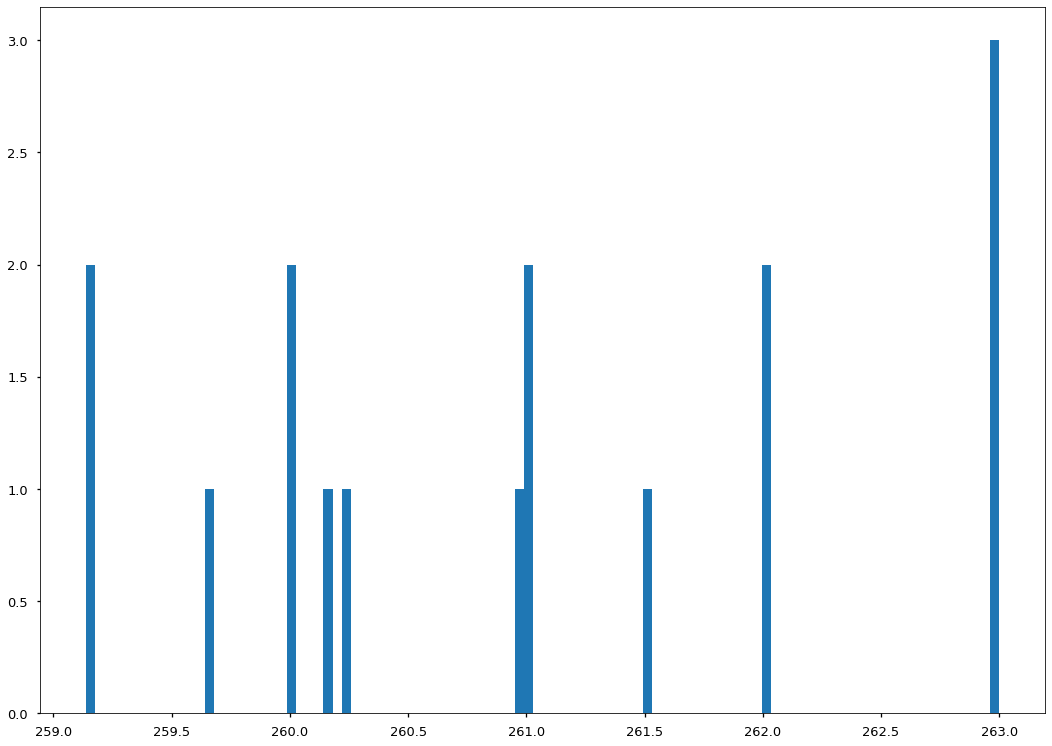

In [324]:
plt.hist(crd[0]['coordinates'][:,0], 100);

2.954932678949186

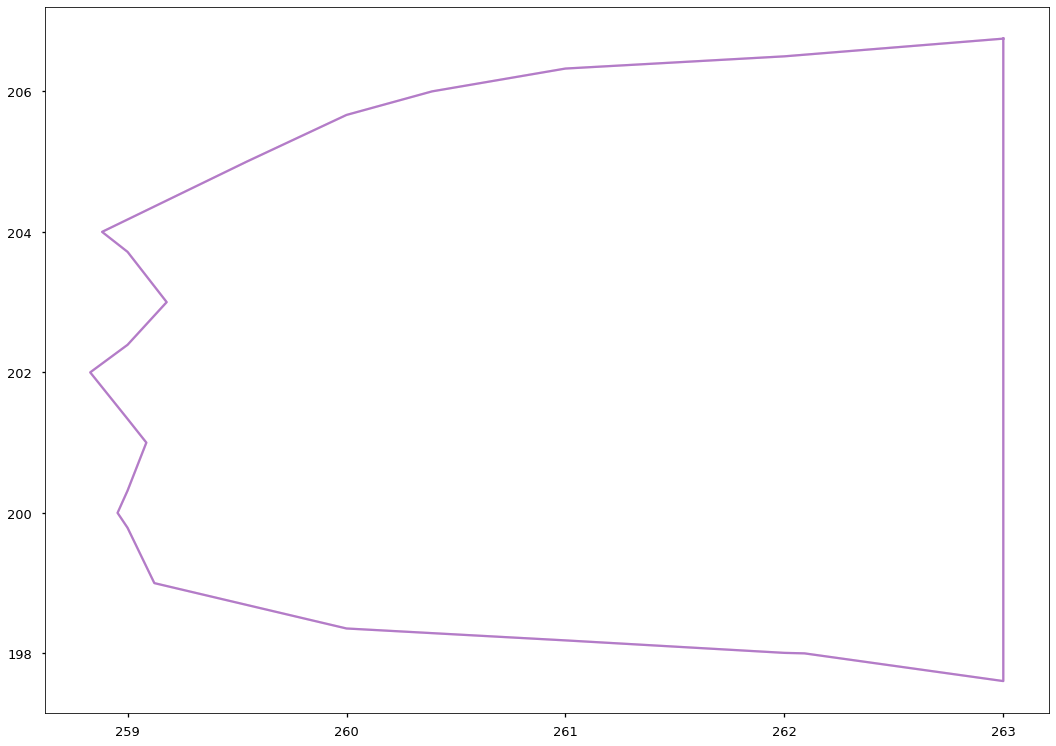

In [310]:
# cell_id = 550
# import pylab as pl
from caiman.utils.visualization import plot_contours, get_contours

# cell_id = 130 # test w edgy cell 742. good cell 130
crd = plot_contours(cnm.estimates.A[:, cell_id], Cn, thr=0.9, display_numbers=False);
plt.close()

# crd_converted = crd[0]['coordinates'].copy()
pl.plot(*crd_converted.T, color='red', alpha=0.3)
plt.plot(*crd_converted.T, color='blue', alpha=0.3);
crd[0]['coordinates']

np.nanmax(crd[0]['coordinates'][:,0])

In [283]:
print(np.nanmax(crd[0]['coordinates'][:,0]) - np.nanmin(crd[0]['coordinates'][:,0]))
np.nanmax(crd[0]['coordinates'][:,1]) - np.nanmin(crd[0]['coordinates'][:,1])

9.52740435714665


9.033693874590767

## area pass

In [266]:
from caiman.base.rois import extract_binary_masks_blob
gSig = [4, 4]

area_arr = []
for component_id in cnm.estimates.idx_components:
    masks_ws, pos_examples, neg_examples = extract_binary_masks_blob(cnm.estimates.A[:, component_id], 
                                                                 neuron_radius=gSig[0], dims=[796, 264])
    area = np.sum(masks_ws)
    area_arr = np.append(area_arr, area)

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skima

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


686

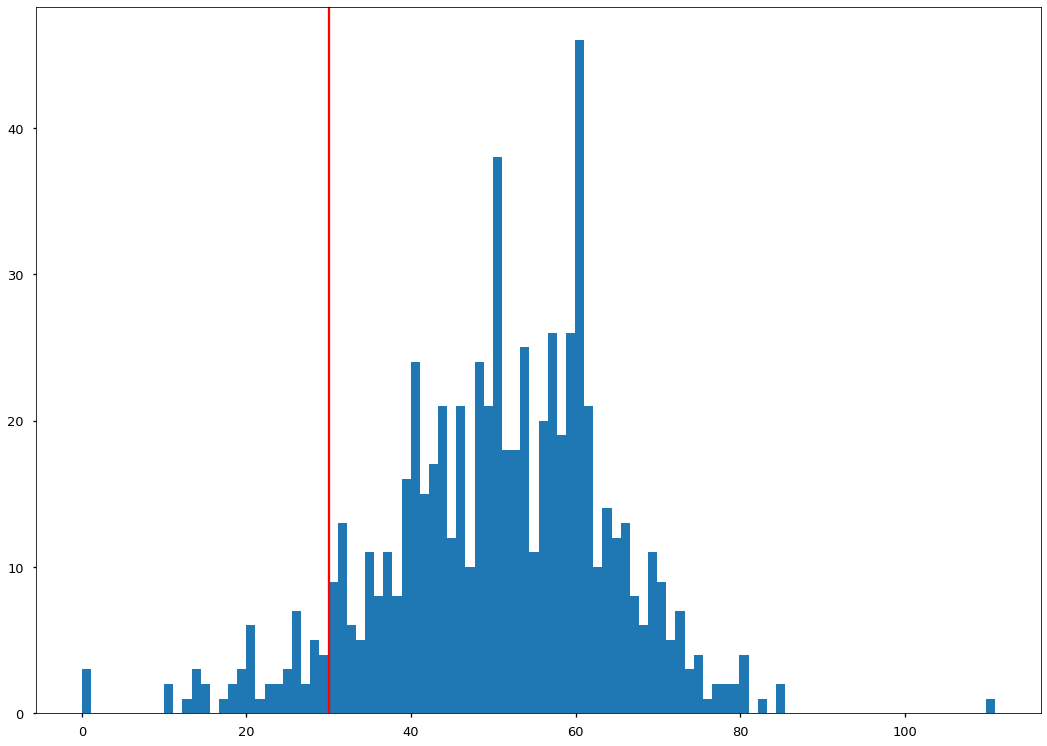

In [272]:
plt.hist(area_arr, 100)
plt.axvline(30, color='r')
len(cnm.estimates.idx_components)

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


20

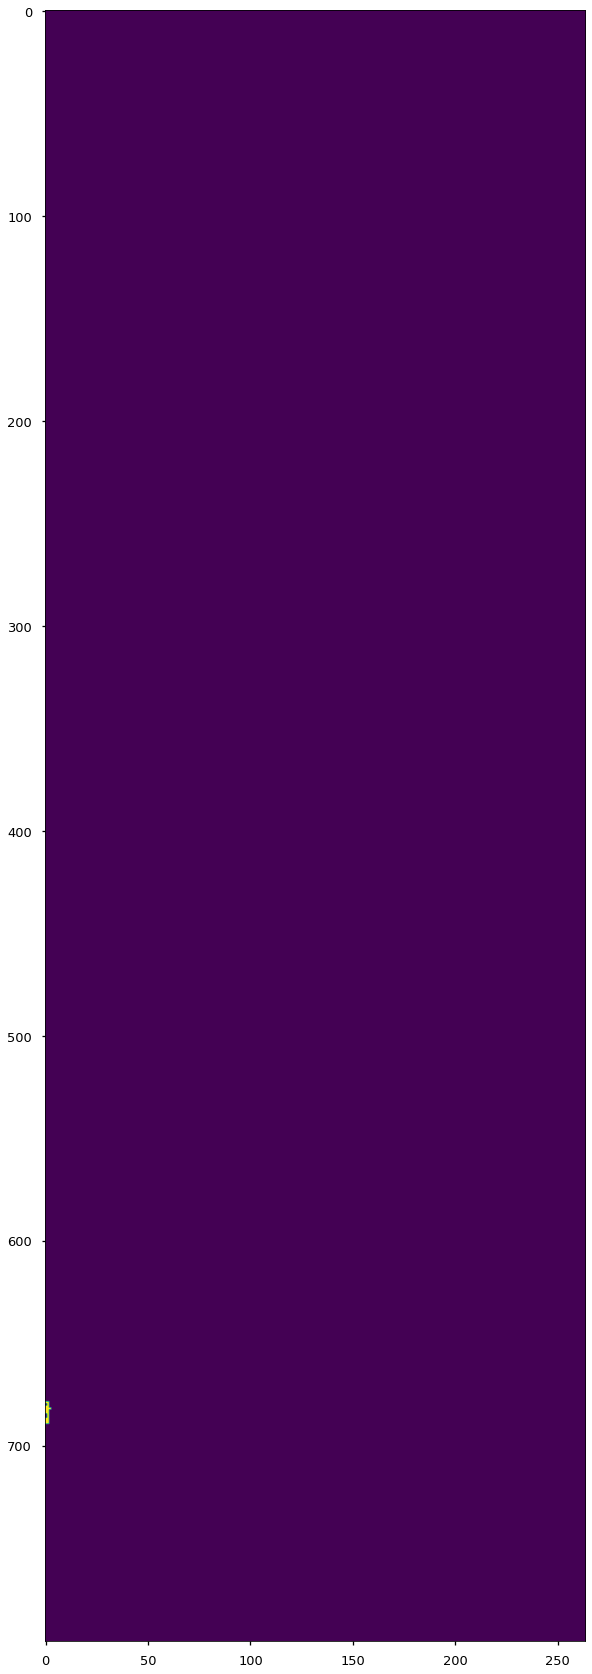

In [250]:

cell_id = 662
masks_ws, pos_examples, neg_examples = extract_binary_masks_blob(cnm.estimates.A[:, cell_id], 
                                                                 neuron_radius=gSig[0], dims=[796, 264])

# plt.figure(figsize=(100,30))
# plt.imshow(np.squeeze(masks_ws))
np.sum(masks_ws)

# Extract activity

(1065, 100000)


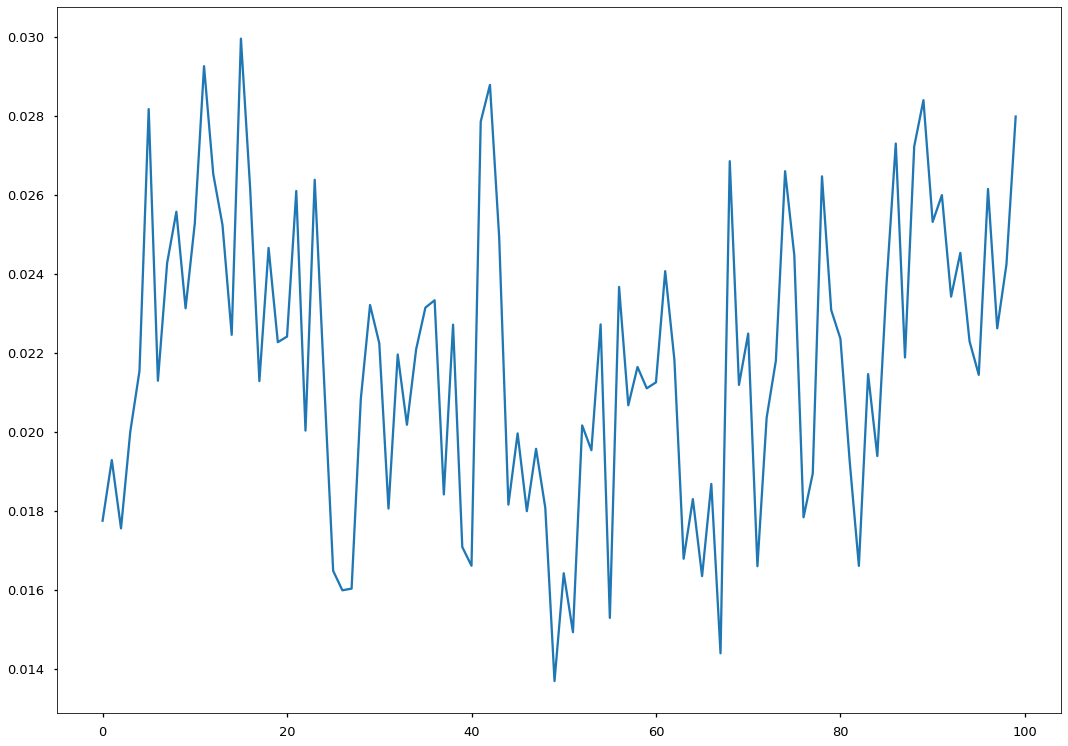

In [80]:
print(cnm.estimates.F_dff.shape)
df_cells = cnm.estimates.F_dff[cnm.estimates.idx_components, :]
df_avg = np.mean(df_cells, axis=0)
df_avg.shape
# df_0 = df_all[0,:]
plt.plot(df_avg[100:200])